# Monitor generative AI with custom metrics

While it gets easier to build generative AI solutions with each passing day, it is becoming evident that it is critical to effectively monitor LLMs and generative AI solutions to measure alignment, return on investment, provide guardrails. Monitoring generative AI solutions or <a href='https://www.pluralsight.com/resources/blog/data/what-is-llmops'>LLMOps</a> is a multi-faceted endeavor and requires more than simple out-of-the-box metrics. Each business is s unique and the solutions they build require customized monitoring metrics. This accelerator aims to illustrate how businesses can use DataRobot to effectively and holistically monitor generative AI solutions, using the metrics relevant to them.

With DataRobot's expertise in the AI and ML domain, this accelerator also aims to provide a segmentation of metrics into themes that should cover the monitoring requirements of a majority of the businesses. However, if there are any themes or metrics that the audience of this notebook is interested in adding, kindly reach out to DataRobot.

## Setup

### Install libraries

Start off by installing the supporting libraries for LLM monitoring.

In [1]:
!pip install openai langchain transformers datarobot datarobotx[llm] tiktoken textstat textblob nltk py-readability-metrics

In [2]:
!python -m textblob.download_corpora

In [3]:
# Initialize the DataRobot client if you are running this code outside of the DataRobot platform
# import datarobot as dr
# dr.Client(endpoint=ENDPOINT,token=TOKEN)

### Use case and dataset

The <a href='https://www.kaggle.com/datasets/muzammalnawaz/container-tracking-data-set'>dataset</a> for this notebook is a publicly available dataset from a fictitious Logistics company hosted on Kaggle.

This accelerator uses tracking data from a container to generate a customer notification email with aim to reduce the number of L1 information calls to the company's call center. This will allow the company to reduce the workload on their support staff and increase their productivity. Each row of the dataset contains tracking information of a shipping container being transported by the fictitious organization. This is an illustrative example, so you can ignore the delivered date and flag columns. 

In [4]:
import pandas as pd

# https://www.kaggle.com/datasets/muzammalnawaz/container-tracking-data-set
df_tracking = pd.read_excel(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/Container+Tracking+Data.xlsx"
)
df_tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   CONTAINER_NUMBER                      1830 non-null   object        
 1   VESSEL_NAME                           1534 non-null   object        
 2   FREIGHT_FORWARDER                     1401 non-null   object        
 3   PLACE_OF_DISPATCH                     1521 non-null   object        
 4   PORT_OF_LOADING                       1577 non-null   object        
 5   PORT_OF_DISCHARGE                     1564 non-null   object        
 6   POST_PORT_OF_DISCHARGE                1507 non-null   object        
 7   PLACE_OF_DISPATCH_DATE                1581 non-null   datetime64[ns]
 8   PORT_OF_LOADING_DATE                  1581 non-null   object        
 9   PORT_OF_DISCHARGE_DATE                1494 non-null   datetime64[ns]
 10  

## Reference text generation

The following cell illustrates a step in the prompt engineering process for the Gen AI solution. Given a container number, it will extract the tracking details and convert the row into a text sequence which can be appended to the LLM prompt.

In [5]:
cols = [
    "CONTAINER_NUMBER",
    "VESSEL_NAME",
    "PREDICTED_DELIVERED_DATE",
    "FREIGHT_FORWARDER",
    "PLACE_OF_DISPATCH",
    "PLACE_OF_DISPATCH_DATE",
    "PORT_OF_DISCHARGE",
    "PORT_OF_DISCHARGE_DATE",
    "PORT_OF_LOADING",
    "PORT_OF_LOADING_DATE",
    "POST_PORT_OF_DISCHARGE",
    "POST_PORT_OF_DISCHARGE_DATE",
]
tracking_dict = df_tracking[cols][df_tracking.CONTAINER_NUMBER == "FCIU8573349"].iloc[0].to_dict()
", ".join([str(k) + " is " + str(v) for k, v in tracking_dict.items()])

'CONTAINER_NUMBER is FCIU8573349, VESSEL_NAME is CAPE SOUNIO, PREDICTED_DELIVERED_DATE is 2021-08-03 00:00:00, FREIGHT_FORWARDER is CIF, PLACE_OF_DISPATCH is Yantian, Guangdong Sheng, China, PLACE_OF_DISPATCH_DATE is 2021-05-18 00:00:00, PORT_OF_DISCHARGE is Long Beach, California, United States, PORT_OF_DISCHARGE_DATE is 2021-07-17 00:00:00, PORT_OF_LOADING is Yantian, Guangdong Sheng, China, PORT_OF_LOADING_DATE is 2021-05-19 00:00:00, POST_PORT_OF_DISCHARGE is Dallas, Texas, United States, POST_PORT_OF_DISCHARGE_DATE is 2021-07-15 00:00:00'

## Basic solution

The following cell shows an unmonitored endpoint created to ingest the container number and use a <a href='https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#gpt-35'>GPT 3.5</a> model to generate a notification email from container tracking data.

In [26]:
import os

from langchain.chat_models import AzureChatOpenAI

OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]
OPENAI_ORGANIZATION = os.environ["OPENAI_ORGANIZATION"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_DEPLOYMENT_NAME = os.environ["OPENAI_DEPLOYMENT_NAME"]

llm = AzureChatOpenAI(
    deployment_name=OPENAI_DEPLOYMENT_NAME,
    openai_api_type=OPENAI_API_TYPE,
    openai_api_base=OPENAI_API_BASE,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=OPENAI_API_KEY,
    openai_organization=OPENAI_ORGANIZATION,
    model_name=OPENAI_DEPLOYMENT_NAME,
    temperature=0,
    verbose=True,
)


def get_completion(CONTAINER_NUMBER):
    tracking_dict = (
        df_tracking[
            [
                "CONTAINER_NUMBER",
                "VESSEL_NAME",
                "PREDICTED_DELIVERED_DATE",
                "FREIGHT_FORWARDER",
                "PLACE_OF_DISPATCH",
                "PLACE_OF_DISPATCH_DATE",
                "PORT_OF_DISCHARGE",
                "PORT_OF_DISCHARGE_DATE",
                "PORT_OF_LOADING",
                "PORT_OF_LOADING_DATE",
                "POST_PORT_OF_DISCHARGE",
                "POST_PORT_OF_DISCHARGE_DATE",
            ]
        ][df_tracking.CONTAINER_NUMBER == CONTAINER_NUMBER]
        .iloc[0]
        .to_dict()
    )
    shipment_info = ", ".join([str(k) + " is " + str(v) for k, v in tracking_dict.items()])
    prompt = (
        "You are customer support agent for a logistics firm. With the enclosed information, \
    check for potential delays and generate an email to the user informing them if their package \
    is on time or not: "
        + shipment_info
    )
    response = llm.predict(prompt)
    return {"completion": response}


print(get_completion("CAIU9631734")["completion"])

Dear [User],
We hope this email finds you well. We wanted to provide you with an update regarding the delivery of your package with the following details:
- Container Number: CAIU9631734
- Vessel Name: CSCL SUMMER
- Predicted Delivered Date: 2022-02-18 00:00:00
- Freight Forwarder: YUEHSNEG
- Place of Dispatch: Tianjin Xingang, Tianjin Shi, China
- Place of Dispatch Date: 2021-12-21 00:00:00
- Port of Discharge: Dallas, Texas, United States
- Port of Discharge Date: 2022-03-29 00:00:00
- Port of Loading: Tianjin Xingang, Tianjin Shi, China
- Port of Loading Date: 2021-12-29 00:00:00
- Post Port of Discharge: Dallas, Texas, United States
- Post Port of Discharge Date: 2022-02-18 00:00:00
Based on the information provided, we regret to inform you that there may be a potential delay in the delivery of your package. The predicted delivered date was set for 2022-02-18, but due to unforeseen circumstances, it is possible that the package may not arrive on time.
We understand the importance o

## Create a deployment

In order to monitor an external model with DataRobot, you need a <a href='https://docs.datarobot.com/en/docs/mlops/deployment/deploy-methods/deploy-custom-inf-model.html'>custom model deployment</a> for unstructured models. The <a 
 href='https://drx.datarobot.com/index.html'>DRX</a> library which is a collection of extensions to the DataRobot library that simplify the process of creating and executing deployments. Once the deployment is created, you can use the `MonitoringConfig` object to understand the input and output of the completion function so that it can log and track the model for LLMOps.

In [7]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment("Monitoring Metrics")
deployment_id

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(…)tary/toxic-bert/resolve/main/config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

(…)-bert/resolve/main/tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

(…)nitary/toxic-bert/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ert/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

'65263bbb9c41de83b164d890'

In [8]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda prompt: {"prompt": prompt},
    output_parser=lambda x: {"answer": x.get("completion")},
    target="answer",
)

## Monitoring metrics

As stated earlier, monitoring a generative AI solution is a multi-faceted task. Organizations would like to monitor their generative AI solutions from different perspectives. The monitoring is done via <a href='https://docs.datarobot.com/en/docs/mlops/monitor/custom-metrics.html#custom-metrics-tab'>custom metrics</a> which align closely to the business and technical KPIs of the solution. The broad themes categorizing the metrics are:

- <b>TCO-based monitoring metrics:</b> These metrics are related to the total cost of ownership of the solution. These can include API costs for the externally hosted LLM and compute costs of the self-hosted LLM.
- <b>UX-based monitoring metrics:</b> These metrics are related to the user experience and user interface of the solution. These can include readability of the response and sentiment in the response.
- <b>Regulatory-based monitoring metrics:</b> These metrics are related to guardrails, safety, and regulatory aspects of the solution. These can include toxicity for abuse prevention, Pronoun disambiguation for bias/discrimination identification, and groundedness for Hallucination identification.
- <b>Business value based monitoring metrics:</b> These metrics are related to the business value or return on investment of the solution. These can include cost savings, productivity improvement, and revenue.

### TCO-based metrics

To understand the <a href='https://www.investopedia.com/terms/t/totalcostofownership.asp#:~:text=Total%20cost%20of%20ownership%20(TCO)%20includes%20the%20purchase%20price%20of,to%20a%20company%20or%20individual.'>Total Cost of Ownership</a> of the solution, the organization will build a metric around the pricing of the GPT 3.5 API provided by Azure. The following function calculates the price per prediction call using token counts calculated using <a href='https://github.com/openai/tiktoken'>Tiktoken</a>. It then multiplies the token counts with the price per token provided in the Azure OpenAI <a href='https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/'>pricing page</a>. If the LLM is self-hosted, metrics around the compute cost are relevant for the organization.

In [9]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")


def get_gpt_token_count(text):
    return len(encoding.encode(text))


def get_gpt_3_5_cost(
    prompt, response, prompt_token_cost=0.0015 / 1000, response_token_cost=0.002 / 1000
):
    return (
        get_gpt_token_count(prompt) * prompt_token_cost
        + get_gpt_token_count(response) * response_token_cost
    )

Once we have our logic ready, we can add the Custom Metric definitions to the deployment. Our hypothetical definition of TCO metric is that the cumulative sum of the cost being less than a 1000 USD for the cycle.

In [10]:
from utilities import create_custom_metric

TCO_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="API Cost",
    baseline="1000",
    type="sum",
    directionality="lowerIsBetter",
)

### UX-based metrics

Another aspect of the solution is the customer experience. Organizations would like to monitor the quality of the response provided by the solution ot LLM as this directly contributes to the UX of the solution. Here, the organization can use the <a href='https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests'>Flesch Readability score</a>, which aims to quantify how intelligible the response is. Flesch scores provide scales to rank a text based on the reading comprehension levels required to understand the text. Generally, a higher score indicates that the text can be understood with basic or high school level comprehension ability. 
<br>The other readability score is the <a href='https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index'>Coleman Liau Index</a>. It measures the readability of the text based on the number of characters and sentences in a given text. There are many text fluency and readability metrics available for use according to the users' requirements.

In [11]:
import textstat


def get_response_readability(response):
    return textstat.flesch_reading_ease(response)


def get_response_cl_index(response):
    return textstat.coleman_liau_index(response)


READABILITY_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="50",
    type="average",
    directionality="higherIsBetter",
)

CL_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Coleman Liau Index",
    baseline="10",
    type="average",
    directionality="lowerIsBetter",
)

### Regulatory and safety metrics

These set of metrics are crucial for the safety and regulatory setup of an organization and its offerings. Identifying abuse, toxicity, polarity, bias, and hallucination in user prompts and model responses can lead to safety violations or much serious outcomes for a business. Using specific metrics for these can help in intervention and resolution.
In this example, you will use DataRobot custom metrics to monitor the <a href='https://en.wikipedia.org/wiki/Sentiment_analysis'>polarity</a> of the response to make sure that the model isn't generating text with a consistent negative outlook. Polarity is the mean of the linewise sentiment of the model response. In applications like chatbots, you can use toxicity and abuse related metrics on user input prompts.

In [12]:
import numpy as np
from textblob import TextBlob


def get_response_polarity(response):
    blob = TextBlob(response)
    return np.mean([sentence.sentiment.polarity for sentence in blob.sentences])


POLARITY_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Polarity",
    baseline="0.5",
    type="average",
    directionality="lowerIsBetter",
)

### Business value-based metrics
Any initiative implemented by an organization is tied to a business value. It can be related to revenue, productivity, or cost optimization. Generative AI solutions are also implemented with a return on investment in view. DataRobot can help implement monitoring metrics around this aspect as well. From the use case perspective, the organization is looking to reduce incoming <a href='https://en.wikipedia.org/wiki/Technical_support#L1_Support'>L1 information calls</a> to the support center. 
<br>This acclerator illustrates a `Potential savings` metric which takes into consideration the email cost and call cost in calculating potential savings. While you may not get the ground truth immediately, you can quickly measure the probability of customer call decline and use the probability as a ceiling in the calculation. Custom Metrics in DataRobot also have the ability to be updated at any point in time, which means you can update the cost calculation metrics after the ground truth is available.
<br>The `Productivity` metric also illustrated is the effort savings in minutes of the call center staff. Assuming the time taken to draft the response with respect to the average typing speed, you can devise a simple productivity savings metric that can be tracked by the organization. This allows the organization to calculate the average or cumulative productivity gained by deploying the generative AI solution.

In [13]:
def get_potential_savings(CONTAINER_NUMBER):
    prob = 0.3
    email_cost = 0.05
    call_cost = 4
    return prob * (call_cost - email_cost)


def get_productivity(response):
    return get_gpt_token_count(response) / 150

In [14]:
SAVINGS_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Potential Savings(USD)",
    baseline="1000",
    type="sum",
    directionality="higherIsBetter",
)

PRODUCTIVITY_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Productivity(minutes)",
    baseline="1000",
    type="sum",
    directionality="higherIsBetter",
)

## Synthesis

Once you have the metric definitions and logic ready, update the completion function to record custom metrics for the deployment. With DataRobot's LLM model monitoring, you can easily start monitoring an existing or new generative AI model with just a few lines of code.
<br> In the below code, implement a simple guard to check and overwrite the model response if the polarity of the output is very negative, for e.g., Shipment is destroyed. 
<br> DataRobot also allows users to implement complicated guardrail models like transformer models, text sequence models, or other LLMs for that matter of fact through the <a href='https://drx.datarobot.com/llm/guard.html#deploying-a-guardrail-model-as-a-custom-unstructured-model'>GuardrailConfig</a> object from the DRX library.

In [15]:
from utilities import submit_custom_metric


@aguard(monitor_config)
async def get_completion(CONTAINER_NUMBER):
    tracking_dict = (
        df_tracking[
            [
                "CONTAINER_NUMBER",
                "VESSEL_NAME",
                "PREDICTED_DELIVERED_DATE",
                "FREIGHT_FORWARDER",
                "PLACE_OF_DISPATCH",
                "PLACE_OF_DISPATCH_DATE",
                "PORT_OF_DISCHARGE",
                "PORT_OF_DISCHARGE_DATE",
                "PORT_OF_LOADING",
                "PORT_OF_LOADING_DATE",
                "POST_PORT_OF_DISCHARGE",
                "POST_PORT_OF_DISCHARGE_DATE",
            ]
        ][df_tracking.CONTAINER_NUMBER == CONTAINER_NUMBER]
        .iloc[0]
        .to_dict()
    )
    shipment_info = ", ".join([str(k) + " is " + str(v) for k, v in tracking_dict.items()])
    prompt = (
        "You are customer support agent for a logistics firm. With the enclosed information, \
    check for potential delays and generate an email to the user informing them if their package \
    is on time or not: "
        + shipment_info
    )
    response = {"completion": llm.predict(prompt)}
    polarity = get_response_polarity(response["completion"])
    if polarity > 0.6:
        response = {
            "completion": "Hi, Can you please call our customer care at xxx-xxx-xxxx for \
        details regarding your shipment. We deeply regret the inconvenience caused."
        }
    try:
        submit_custom_metric(
            deployment_id, TCO_CUSTOM_METRIC_ID, get_gpt_3_5_cost(prompt, response["completion"])
        )
        submit_custom_metric(
            deployment_id,
            READABILITY_CUSTOM_METRIC_ID,
            get_response_readability(response["completion"]),
        )
        submit_custom_metric(
            deployment_id, SAVINGS_CUSTOM_METRIC_ID, get_potential_savings(CONTAINER_NUMBER)
        )
        submit_custom_metric(
            deployment_id, PRODUCTIVITY_CUSTOM_METRIC_ID, get_productivity(response["completion"])
        )
        submit_custom_metric(deployment_id, POLARITY_CUSTOM_METRIC_ID, polarity)
        submit_custom_metric(
            deployment_id, CL_CUSTOM_METRIC_ID, get_response_cl_index(response["completion"])
        )
    except Exception as e:
        print(e)
    return response


answer = await get_completion("CAIU9631734")
print(answer["completion"])

Dear [User],
We hope this email finds you well. We wanted to provide you with an update regarding the delivery of your package with the following details:
- Container Number: CAIU9631734
- Vessel Name: CSCL SUMMER
- Predicted Delivered Date: 2022-02-18 00:00:00
- Freight Forwarder: YUEHSNEG
- Place of Dispatch: Tianjin Xingang, Tianjin Shi, China
- Place of Dispatch Date: 2021-12-21 00:00:00
- Port of Discharge: Dallas, Texas, United States
- Port of Discharge Date: 2022-03-29 00:00:00
- Port of Loading: Tianjin Xingang, Tianjin Shi, China
- Port of Loading Date: 2021-12-29 00:00:00
- Post Port of Discharge: Dallas, Texas, United States
- Post Port of Discharge Date: 2022-02-18 00:00:00
Based on the information provided, we regret to inform you that there may be a potential delay in the delivery of your package. The predicted delivered date was set for 2022-02-18, but due to unforeseen circumstances, it is possible that the package may not arrive on time.
We understand the importance o

In [24]:
answer = await get_completion("FCIU8573349")
print(answer["completion"])

Dear [Customer],
We hope this email finds you well. We would like to provide you with an update regarding the delivery of your package with the following details:
- Container Number: FCIU8573349
- Vessel Name: CAPE SOUNIO
- Predicted Delivered Date: 2021-08-03 00:00:00
- Freight Forwarder: CIF
- Place of Dispatch: Yantian, Guangdong Sheng, China
- Place of Dispatch Date: 2021-05-18 00:00:00
- Port of Discharge: Long Beach, California, United States
- Port of Discharge Date: 2021-07-17 00:00:00
- Port of Loading: Yantian, Guangdong Sheng, China
- Port of Loading Date: 2021-05-19 00:00:00
- Post Port of Discharge: Dallas, Texas, United States
- Post Port of Discharge Date: 2021-07-15 00:00:00
Based on the provided information, we are pleased to inform you that your package is currently on track and expected to be delivered on time. The predicted delivered date is set for 2021-08-03. 
We understand the importance of timely delivery and assure you that our team is working diligently to ens

In [23]:
answer = await get_completion(df_tracking.CONTAINER_NUMBER.sample(1).iloc[0])
print(answer["completion"])

Dear [User],
We hope this email finds you well. We would like to provide you with an update regarding the delivery of your package with the following details:
- Container Number: CXDU2326893
- Vessel Name: ONE MISSION
- Predicted Delivered Date: 2022-02-10 00:00:00
- Freight Forwarder: YUE SHENG
- Place of Dispatch: Ningbo, Zhejiang Sheng, China
- Place of Dispatch Date: 2021-12-16 00:00:00
- Port of Discharge: Houston, Texas, United States
- Port of Discharge Date: 2022-01-30 00:00:00
- Port of Loading: Ningbo, Zhejiang Sheng, China
- Port of Loading Date: 2021-12-22 00:00:00
- Post Port of Discharge: Houston, Texas, United States
- Post Port of Discharge Date: 1900-01-01 00:00:00
Based on the provided information, we regret to inform you that there may be a potential delay in the delivery of your package. The predicted delivered date was set for 2022-02-10, but due to unforeseen circumstances, the package has not yet reached its final destination.
We understand the importance of time

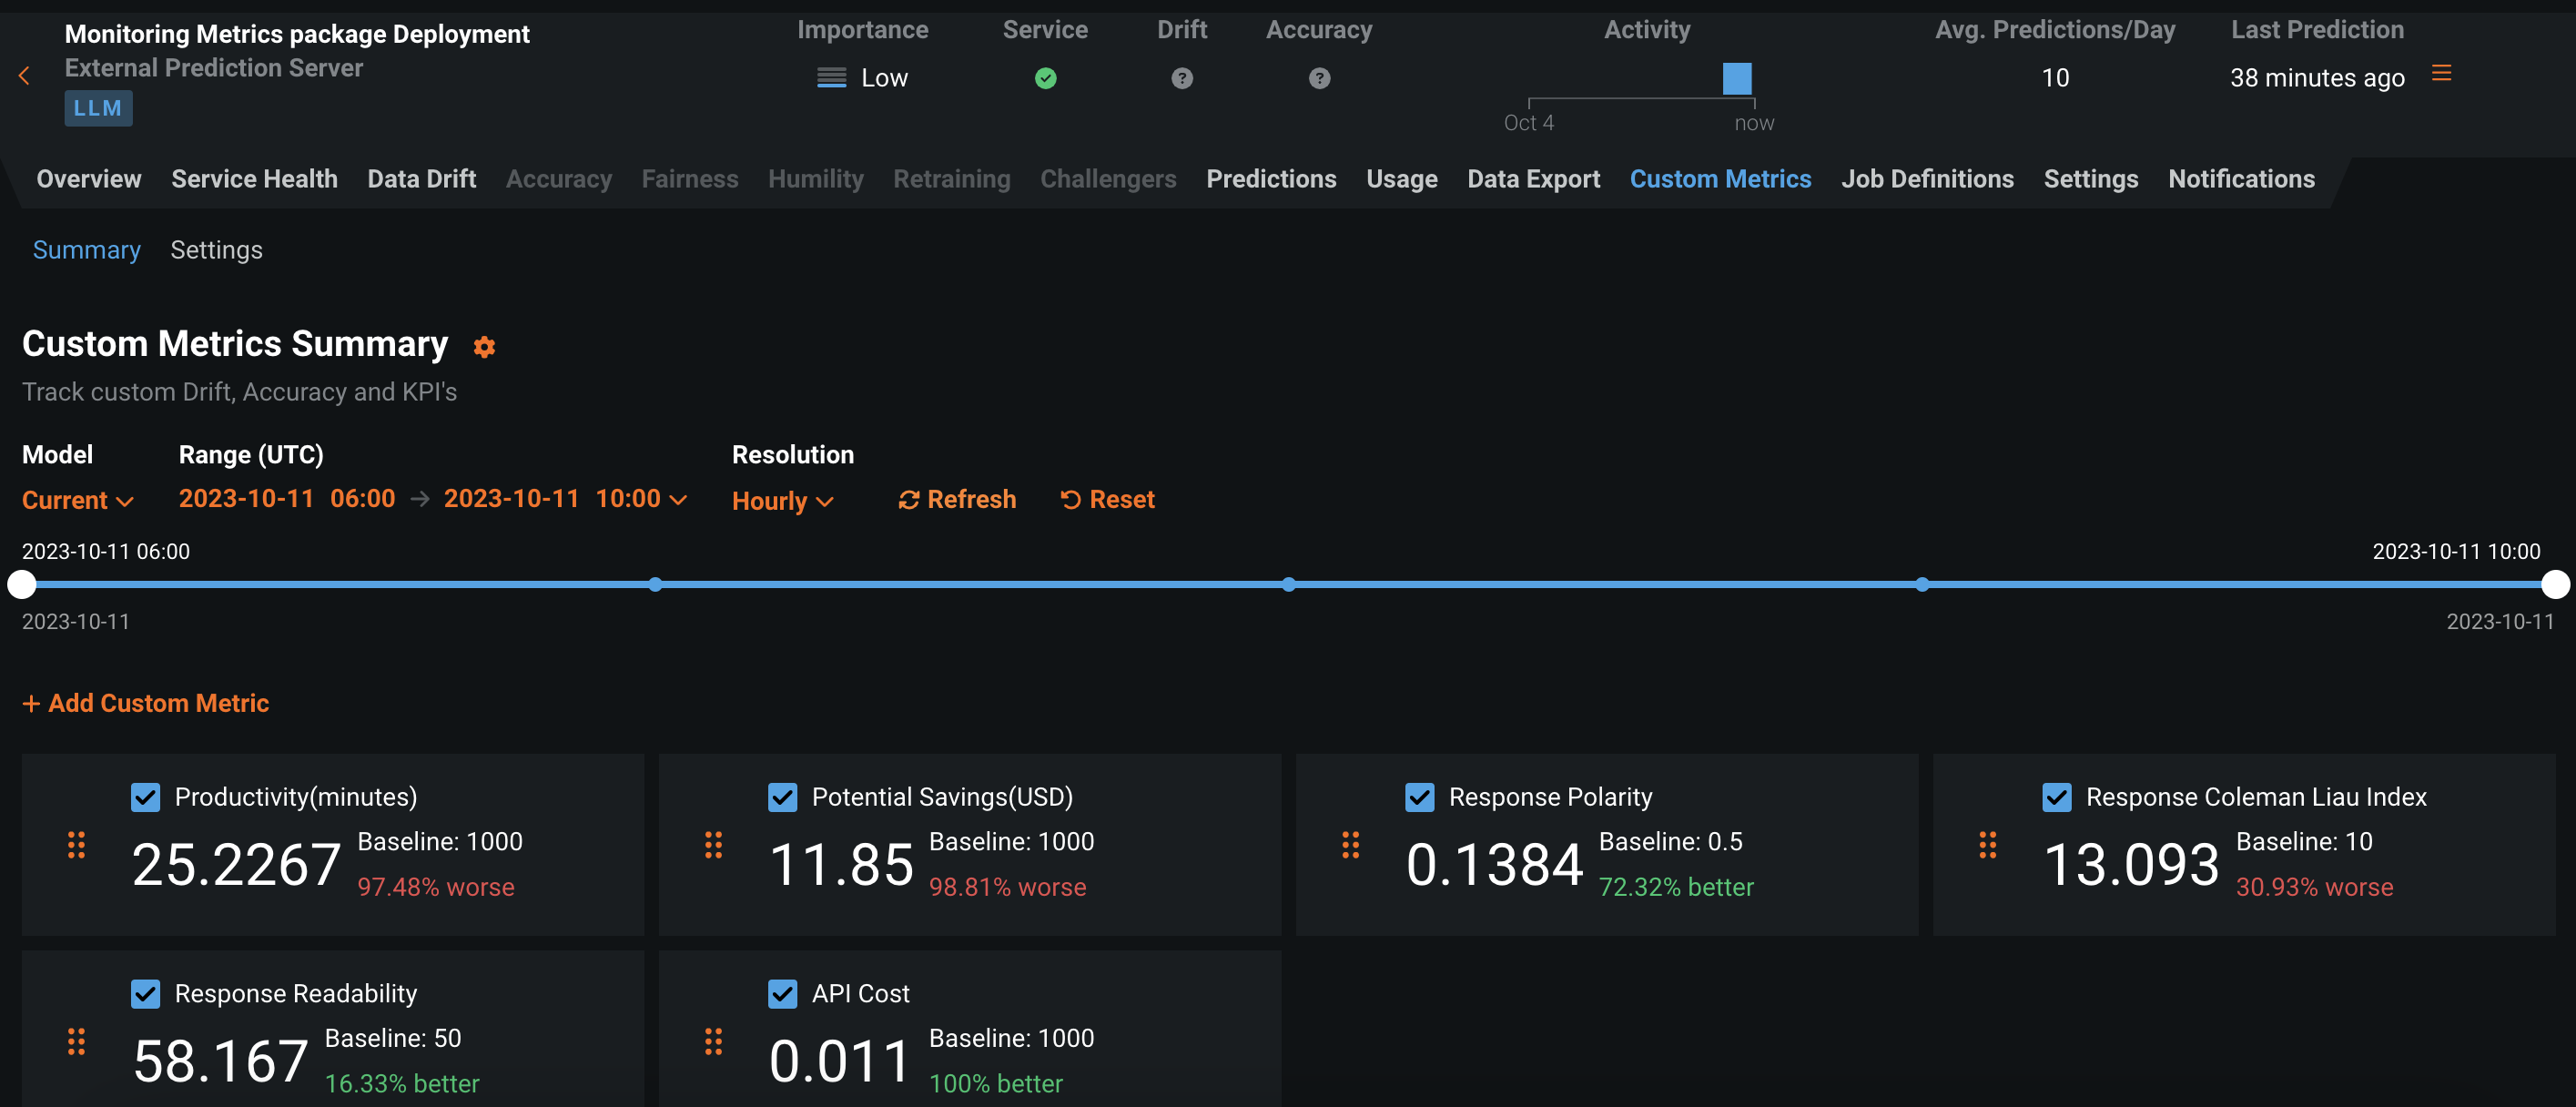

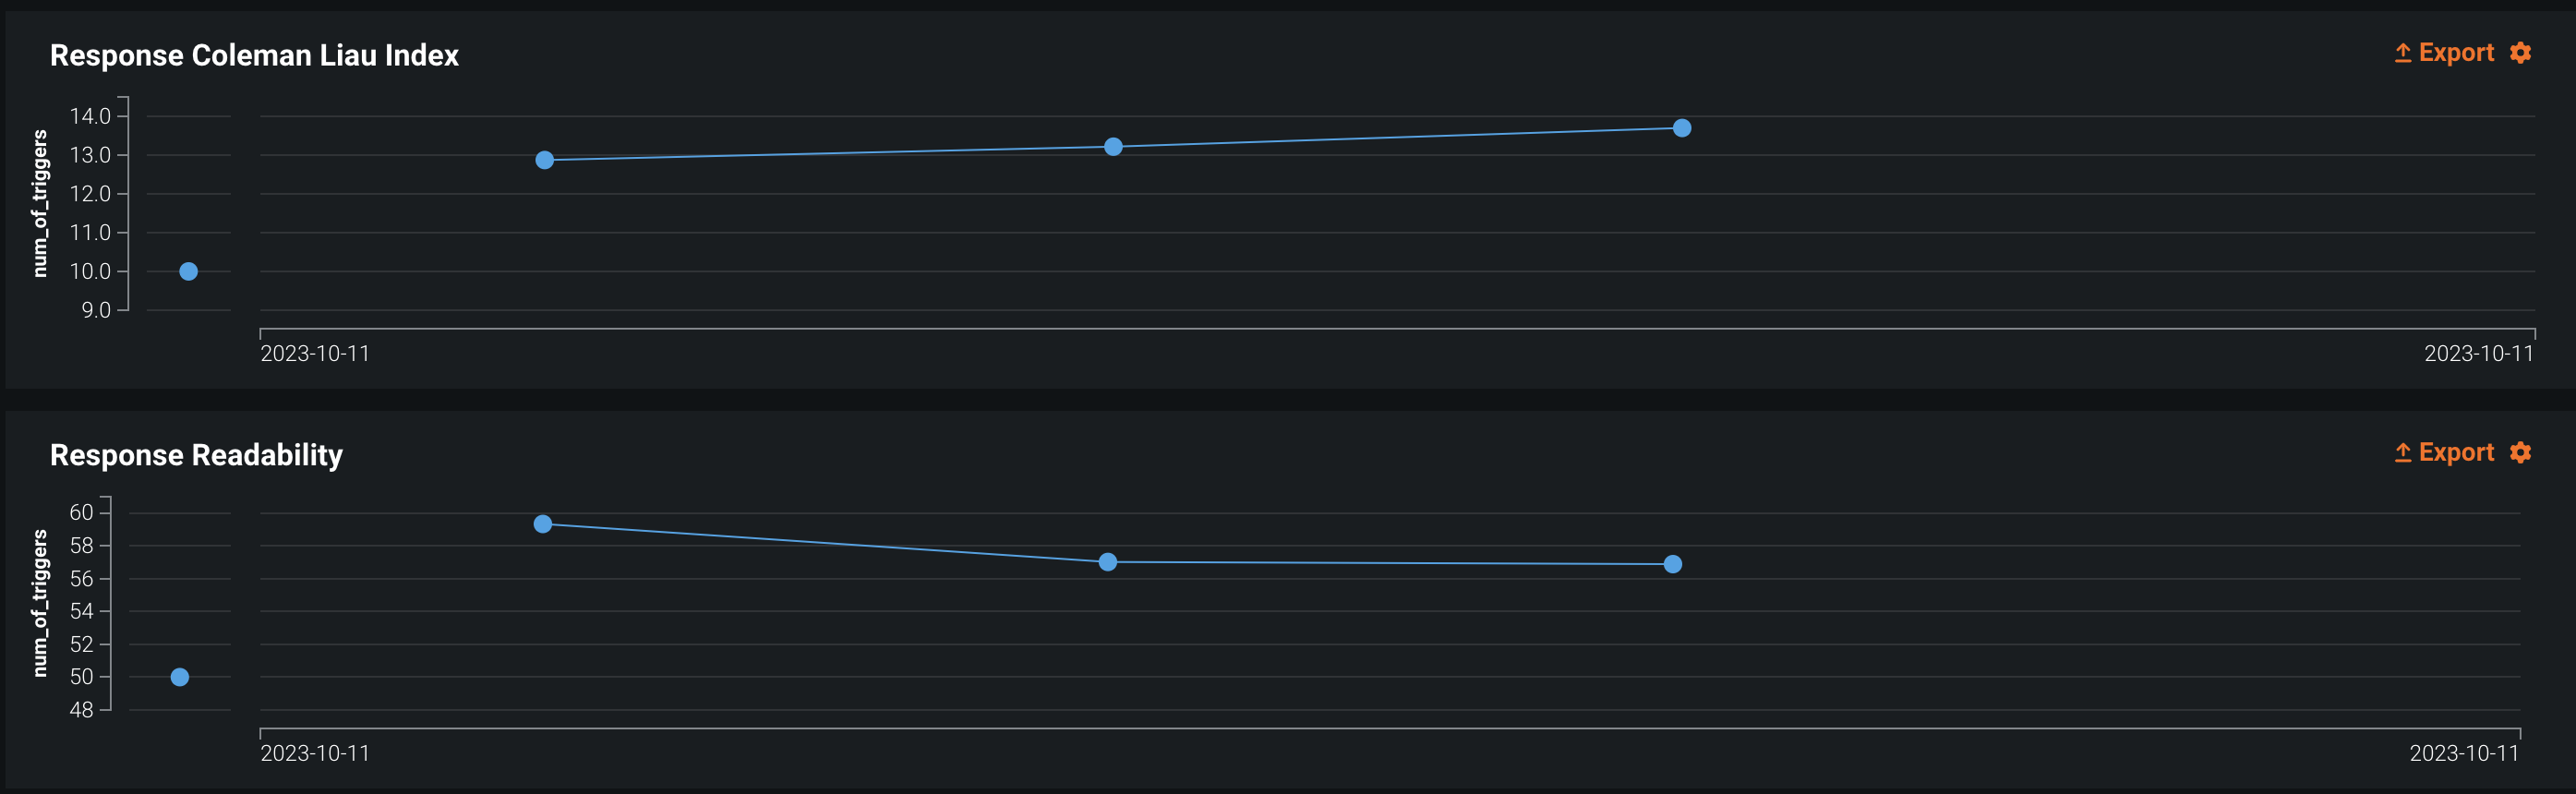

## Conclusion

This accelerator illustrates how you can use DataRobot to effectively monitor LLMs using complete freedom to define customized metrics and external model monitoring deployments. In the process, you are also able to segment the metrics into themes relevant to the organization and users of the generative AI solutions.